# Implementation of a research paper Recommender System

In this assignment, you will build and test a research paper Recommender System. You can use to this end the approach you prefer (*Content-based Filtering* or *Collaborative Filtering*).

In this task, you will the dataset shared in the [data/ResearchPapersDataset](https://drive.google.com/drive/folders/1lNnzw9dZ1UKf92cFhInVte6EkgBzzljp?usp=sharing) folder.

The dataset comprises information about:

*   **Research papers**: The information of the research papers is stored in the *ResearchPapers.csv* file. 
*   **User rating**: The information about the ratings of the users. This information is stored the *UserInteractions.csv* file.

## Description of the files

The information about the research papers consists of:

*   **Id**: identifier of the research paper in the catalog. 
*   **Title**: Title of the research paperq
*   **Topic list**: a list of topics that describe the content of the paper
*   **Abstract**: The abstract of the paper (some papers may not have this information)

The information about the user ratings consists of:

*   **Id**: User Id
*   **Name**: Research paper id
*   **Session id**: Identifier of the session in which the rating was applied
*   **Rating**: The rateing given by the user to the book. This value is in a 1-4 scale.










## Load the libraries




In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import defaultdict
import re

## Load the data



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/LAP/Subjects/AP2/assignments

/content/drive/MyDrive/LAP/Subjects/AP2/assignments


In [4]:
data_dir = '../data/ResearchPapersDataset/'
ratings_file = data_dir + 'UserInteractions.csv'
papers_file = data_dir + 'ResearchPapers.csv'

Before loading the data from the corresponding CSV files, we are going to implement a class that will keep the information of the papers.

In [45]:
# Define a class that contains the metadata of the paper catalog
class PaperData:

    def __init__(self, paperFile):
        self.loadAndProcessData(paperFile)

    def loadAndProcessData(self, paperFile):
        paper_data = pd.read_csv(paperFile, sep=";", 
                                 names=["paperId", "title", "topicList", "abstract"])

        paper_data['representation'] = paper_data['topicList']

        ## Remove unnecesary columns
        paper_data.drop(['topicList', 'abstract'], axis='columns', inplace=True)

        self.paper_data = paper_data
        self.paper2idx = pd.Series(paper_data.index, index=paper_data['paperId'])
        self.paperIds = np.unique(paper_data['paperId'])

    def getPaperIds(self):
        return self.paperIds

    def getPaperIdx(self, paperId):
        idx = self.paper2idx[paperId]
        if type(idx) == pd.Series:
            idx = idx.iloc[0]
        return idx

    def getPaperRepresentations(self):
        return self.paper_data['representation']

    def getPaperInfo(self, paperId):
        idx = self.getPaperIdx(paperId)
        paper = self.paper_data.iloc[idx]

        return {'paperId': paper['paperId'],
                'title': paper['title']}

Let's load the date and inspect the available information. On the one hand, we will obtain the information about the papers. On the other hand, we will also get the ratings of the user, which will allow the recommender system to infer the preferences of the users.


In [52]:
## Load paper data and rating data.
paperData = PaperData(papers_file)
paperRatings = pd.read_csv(ratings_file, sep=";", 
                           names=["userId", "datetime", "sessionId", "paperId", "rating"])
paperRatings.drop('sessionId', axis='columns', inplace=True)

In [53]:
paperData.paper_data

,paperId,title,representation
0,b'4c3535d8d8993c53ab5913f37c96a6c9688dd431',b'Construction of an Idiom Corpus and its Appl...,"['climate forecast system', 'language-independ..."
1,b'3296752a29c83380219e4fa85e90d7310265f548',b'A Review on Word Sense Disambiguation',"['dictionary [publication type]', 'information..."
2,b'1dee505b260b59edbd9bac4bc29e85a1d4c4f908',b'Why Build Another Part-of-Speech Tagger ? A ...,"['acquired immunodeficiency syndrome', 'algori..."
3,b'ac20da2a10ef8b07679c8dc951ed342b704a72fd',b'A Case Study On Inter-Annotator Agreement Fo...,"['body of uterus', 'brown corpus', 'class', 'c..."
4,b'12d8236671771531fbef46a052c7c9f57389107e',b'HLT-NAACL 2007 TextGraphs-2 : Graph-Based Al...,"['algorithm', 'data (computing)', 'directed gr..."
...,...,...,...
1501,b'0e152c2f62ea1a863284eaaf0336e6d6aa2e400c',b'PUTOP: Turning Predominant Senses into a Top...,"['algorithm', 'generative model', 'information..."
1502,b'ebd6669550e37329d768f50c143bc0ea3cc4fcd9',b'Chinese Word Sense Disambiguation based on C...,"['bayesian network', 'microsoft word for mac',..."
1503,b'c681ee2d7930bfe01bc3d92f943f7a3e27115f43',b'Advancements on Nlp Applications for Manipur...,"['body of uterus', 'computer science', 'dictio..."
1504,b'12c90614c7b1afa39858c123505d9456effb2bed',b'A real-time recommender system based on hybr...,"['algorithm', 'collaborative filtering', 'data..."


In [54]:
paperRatings

,userId,datetime,paperId,rating
0,NLP_1878,2021-01-18 01:50:00,b'4c3535d8d8993c53ab5913f37c96a6c9688dd431',4
1,NLP_1878,2021-01-20 20:46:00,b'3296752a29c83380219e4fa85e90d7310265f548',4
2,NLP_1878,2021-01-23 19:05:00,b'1dee505b260b59edbd9bac4bc29e85a1d4c4f908',4
3,NLP_1878,2021-01-27 01:40:00,b'ac20da2a10ef8b07679c8dc951ed342b704a72fd',4
4,NLP_1878,2021-01-31 16:38:00,b'12d8236671771531fbef46a052c7c9f57389107e',4
...,...,...,...,...
1741334,SCD_1417,2021-04-17 10:20:00,b'946d4d20db1c3d9b5ab2819c9bc26e4aaf17526e',1
1741335,SCD_1417,2021-04-19 19:48:00,b'5b2de177de96dcffa533f5efe9d88bc6c8cbf373',1
1741336,SCD_1417,2021-04-24 07:10:00,b'3b57a2e6a702b0320156e0fc6875f8b36dfa506d',1
1741337,SCD_1417,2021-04-24 20:45:00,b'f42c80729c45de365c2dae03ca7194d0370f933a',1


Next, we will explore how the ratings are distributed.

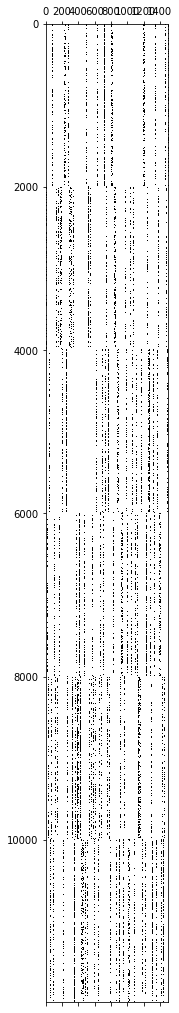

In [48]:
user_paper_rating = paperRatings.pivot_table(index='userId', columns='paperId', values='rating')

fig = plt.figure(figsize=(18, 18))
plt.spy(user_paper_rating)

As can be observed, we are dealing with a very sparse rating matrix. This is positive considering the business perspective. There are a lot of items that may interest the user and that the user is not aware. On the other hand, the information we have a about (some) users is very limited. In fact, we can only be sure whether or not the recommendations are appropriate for those items the user actually rated.

## Preprocess the data

You may need to prepare before training your Recommender System. For instance, you may need to create dictionaries or vocabularies to link *user ids* or *research paper ids* with their models, embeddings, ...

In [ ]:
## Todo preprocess the dataset

## Create the train and test datasets

Split the rating data into the *train* and *test* sets. Observe that there is no timestamp of the ratings. Therefore, you can just split the data randomly.

A Recommender System must be able to recommend items the user has not previously consume. In order to analyse if the Recommender System is working, the rating dataset will be split into the *training* and the *test* set.

In [56]:
def getTrainAndTestSets(data, proportion=0.8):
    ranks = data.groupby('userId')['datetime'].rank(method='first')
    counts = data['userId'].map(data.groupby('userId')['datetime'].apply(len))
    select = (ranks / counts) > proportion

    trainset = data[select == False]
    testset = data[select]

    return trainset, testset


train_set, test_set = getTrainAndTestSets(paperRatings)

Once the *train set* and the *test set* have been defined, we can run the recommender system, using the *train set* to learn the preferences of the users and the *test set* to determine if the recommendations might be appropriate.

## Build your model

Implement your Research Paper Recommender System. You can use the approach you prefer (Content-based Filtering or Collaborative Filtering). 

This recommender system will use TF-IDF to model the papers. The preferences will be inferred from the papers the users liked (rating >= 3.5).


In [58]:
class TFIDF_CBFRecommender:

    def __init__(self, paperData, threshold):
      self.paper_data = paperData
      self.threshold = threshold
        # Create the TFIDF models of the papers
      self.paper_models = self.__createPaperTFIDFModel(
          self.paper_data.getPaperRepresentations())

    
    # This function returns a matrix contraining the TFIDF representations of the papers
    def __createPaperTFIDFModel(self, paperRepresentations, maxFeatures = 2000):
        tfidf = TfidfVectorizer(max_features = maxFeatures)
        # return the paper models
        return tfidf.fit_transform(paperRepresentations)
        

    # Returns the tfidf model of paper paperId
    def __getPaperModel(self, paperId):
        paperIdx = self.paper_data.getPaperIdx(paperId)
        return self.paper_models[paperIdx]

    def __getUserModel(self, userId):
        return self.user_models[userId]

    # get the target papers for the user userId
    # only consider the papers the user did not consume (rate)
    def __getTargetPapersForUser(self,userId):
        #delete the papers the user has already consumed
        if userId not in self.user_models.keys():
            raise Exception("User unknown")
        ratedPapers = self.user_rated_papers[userId]
        return list(set(self.paper_data.getPaperIds()) - set(ratedPapers))

        #we should always check that info we input in the model is clean, that's why I put the "if construction"
        #substract the elements from the set of getPaperIds 

    def fit(self, trainData):
        userModels = {}
        userRatedPapers = defaultdict(list)
        #the recommender system can do the recommendationprocess
        #this starts by creating an empty dict of user models and another
        #for user rated papers.
        # defaultdict -> the first user creates an empty list
        #process the trainData to infer the user models
        for userId, paperId, rating in zip(trainData['userId'],
                                           trainData['paperId'],
                                           trainData['rating']):
            #we inspect whether or not the rating is beyond the threshold
            #in that case we upload the user
            #add the paper to the user history
            userRatedPapers[userId].append(paperId)
            if rating >= self.threshold:
                #update the user model by summing the paper model
                paperModel = self.__getPaperModel(paperId)
                if userId not in userModels.keys():
                    #we put .get(userId,None) bcs the dict is empty
                    #if you can't find something the user would be None
                    #also we can do this:
                    #if userModels.get(userId,None) is None:
                    userModels[userId] = paperModel
                else:
                    userModels[userId] = userModels[userId] + paperModel
                    # we sum the papermodel and save it in the userModels dictionary
        self.user_models = userModels
        self.user_rated_papers = userRatedPapers

    def predict(self, userId, paperId):
        if userId not in self.user_models.keys() or paperId not in self.paper_data.getPaperIds():
            raise Exception("User or paper unknown")

        # obtain the user model and the paper model and compare them
        userModel = self.__getUserModel(userId)
        paperModel = self.__getPaperModel(paperId)
        addequacy = cosine_similarity(userModel, paperModel)[0,0]
        return paperId, addequacy
        # in the predict function we return two values (paperId and addeq)
        # we can use this tuple to obtain the predictions shorter

    def getRecommendationsForUser(self, userId, n=10):
        # check the userId is not in our user models
        if userId not in self.user_models.keys():
            raise Exception('User unknown')
        
        # get the target papers
        targetPapers = self.__getTargetPapersForUser(userId)
        predictions = [self.predict(userId, paperId) for paperId in targetPapers]
        sortedByRanking = sorted(predictions, key = lambda tup: tup[1], reverse = True)
        # the second element of the tuple is the rating 'tup[1]'
        
        return sortedByRanking[:n]

    def getUserModels(self):
        return self.user_models

## Train recommender system

In [60]:
recommender = TFIDF_CBFRecommender(paperData, 3.5)
recommender.fit(train_set)

## Test recommender system
Use the metrics you consider more appropriate. Justify your selection

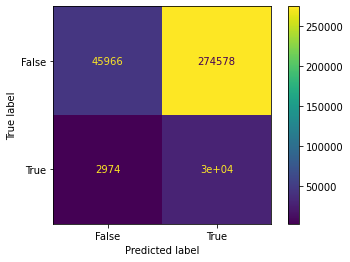

In [61]:
predictedAddequacies = []
realAddequacies = []

for userId, paperId, rating in zip(test_set['userId'], test_set['paperId'], test_set['rating']):
    realAddequacy = rating > 3.5
    realAddequacies.append(realAddequacy)
    try:
        addequacyScore = recommender.predict(userId, paperId)[1]
        addequacy = addequacyScore > 0.3
    except Exception:
        addequacy = False
    predictedAddequacies.append(addequacy)

cm = confusion_matrix(realAddequacies, predictedAddequacies)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels= ['False', 'True'])
disp.plot()
plt.show()

## Get the recommendations for a particular user

In the previous section, we measured the appropriateness of the recommendations. However, this procedure has some limitations. We do not really know whether or not the users disliked the papers they did not rate. On the other hand, we have used some fixed thresholds to *infer liked papers*. However, the users may use different rating ranges.

Observing the recommendations might be appropriate to see the suggestions the users receive.

In [ ]:
recommender.fit(paperRatings)

In [65]:
recommendationsForUserNLP_1878 = recommender.getRecommendationsForUser("NLP_1878")

for paperId, addequacy in recommendationsForUserNLP_1878:
    paperInfo = paperData.getPaperInfo(paperId)
    title = paperInfo['title']
    print("Paper Id: {}, Title: {} Addequacy: {}".format(paperId, title, addequacy))

Paper Id: b'eea4ca4844525dcc64c037697b2bf45b7e7b8254', Title: b'Knowing a word (sense) by its company' Addequacy: 0.7017009591268266
Paper Id: b'6cd6edc1da963d148a03a97c0b78ebfb8597a131', Title: b'Is Word Sense Disambiguation just one more NLP task?' Addequacy: 0.6576545368635137
Paper Id: b'90dd9a6e63320a18f8f50792996ba605cc874fe6', Title: b'An Empirical Study of the Domain Dependence of Supervised Word Disambiguation Systems' Addequacy: 0.6543248209520927
Paper Id: b'02b542ea379a0eec758550fabb357d116c584ff9', Title: b'Learning Expressive Models for Word Sense Disambiguation' Addequacy: 0.646965810354159
Paper Id: b'4134bd810bbfd7671156c9b3a8ea8f4f38e7c3f4', Title: b'Modified Random Walk Algorithm to Improve the Efficiency of Word Sense Disambiguation ( WSD' Addequacy: 0.6281681262980442
Paper Id: b'7b9e0836467e4933a35e118409d5daec491bb6b4', Title: b'NAACL HLT 2009 Unsupervised and Minimally Supervised Learning of Lexical Semantics' Addequacy: 0.6175508352231097
Paper Id: b'27ec7a2838

The suggestions can be compared to the items the user really liked. This way we could see whether or not they look appropriate. 

In [66]:
print("Papers liked by user NLP_1878")
for userId, paperId, rating in zip(paperRatings['userId'], paperRatings['paperId'], paperRatings['rating']):
    if userId == "NLP_1878" and rating > 3.5:
        paperInfo = paperData.getPaperInfo(paperId)
        title = paperInfo['title']
        print("Paper Id: {} Title: {} Rating: {}".format(paperId, title, rating))

Papers liked by user NLP_1878
Paper Id: b'4c3535d8d8993c53ab5913f37c96a6c9688dd431' Title: b'Construction of an Idiom Corpus and its Application to Idiom Identification based on WSD Incorporating Idiom-Specific Features' Rating: 4
Paper Id: b'3296752a29c83380219e4fa85e90d7310265f548' Title: b'A Review on Word Sense Disambiguation' Rating: 4
Paper Id: b'1dee505b260b59edbd9bac4bc29e85a1d4c4f908' Title: b'Why Build Another Part-of-Speech Tagger ? A Minimalist Approach' Rating: 4
Paper Id: b'ac20da2a10ef8b07679c8dc951ed342b704a72fd' Title: b'A Case Study On Inter-Annotator Agreement For Word Sense Disambiguation' Rating: 4
Paper Id: b'12d8236671771531fbef46a052c7c9f57389107e' Title: b'HLT-NAACL 2007 TextGraphs-2 : Graph-Based Algorithms for Natural Language Processing' Rating: 4
Paper Id: b'0407ad810e0e0180c5b8c2638e31be1762ae31b7' Title: b'A Flexible POS Tagger Using an Automatically Acquired Language Model' Rating: 4
Paper Id: b'39ccbe58d3c97ce37e1f4e671ed05a87bd2a559d' Title: b'Word Sen

## Look for a user that might have similar tastes to yours and display the recommendations for that user

Then, place your opinion about the recommendations. Are they appropriate? Would you prefer more diversity?